---
## Informatics Network Analysis

### Importing Data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, csv

In [2]:
# The lookup tables:
lookup_poinf = pd.read_pickle(
    path='../data/lookup_poinf.pkl')
lookup_pub = pd.read_pickle(
    path = '../data/lookup_pub.pkl')


---
## Drawing the gaph

In [3]:
# use networkx to create a full graph for this dataset:
import networkx as nx

In [8]:
all_edges = []
for listEdges in lookup_pub.edges:
    all_edges.extend(listEdges)

### Global statistics

In [9]:
g_full = nx.from_edgelist(all_edges)

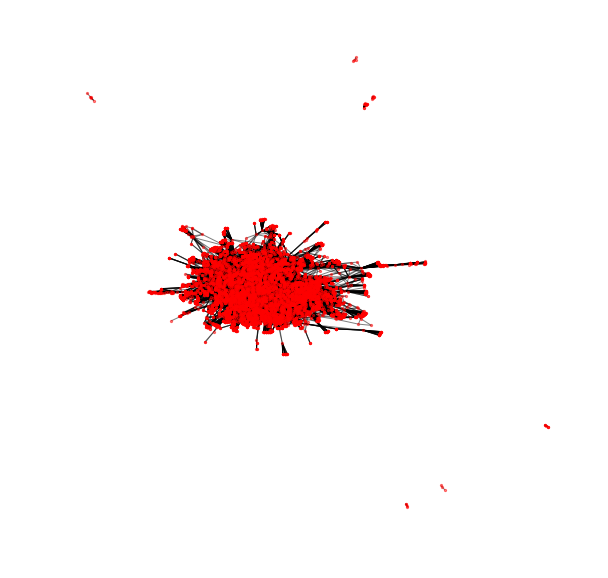

In [53]:
# visualise:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
nx.draw(G=g_full, pos=nx.spring_layout(g_full), ax=ax, alpha=0.5, node_size=5)

In [10]:
g_full.name = 'Full collaboration Graph'
print nx.info(g_full)

Name: Full collaboration Graph
Type: Graph
Number of nodes: 7898
Number of edges: 35866
Average degree:   9.0823


#### Degree distribution

#### Clustering

In [67]:
# The clustering coefficient for each nodes
c_coeff_nodes = nx.clustering(g_full)

In [82]:
# Average clustering coefficient
avg_c_coeff = np.mean(c_coeff_nodes.values())
print 'Average clustering coefficient:', avg_c_coeff

Average clustering coefficient: 0.813008680136


In [69]:
# The number of triangles for each nodes
triangle_nodes = nx.triangles(g_full)

In [83]:
transitivity_graph = nx.transitivity(g_full)
print 'Transitivity:',transitivity_graph

Transitivity: 0.291053234318


#### Distance Measure for GCC

In [11]:
Gcc=sorted(nx.connected_component_subgraphs(g_full), key = len, reverse=True)


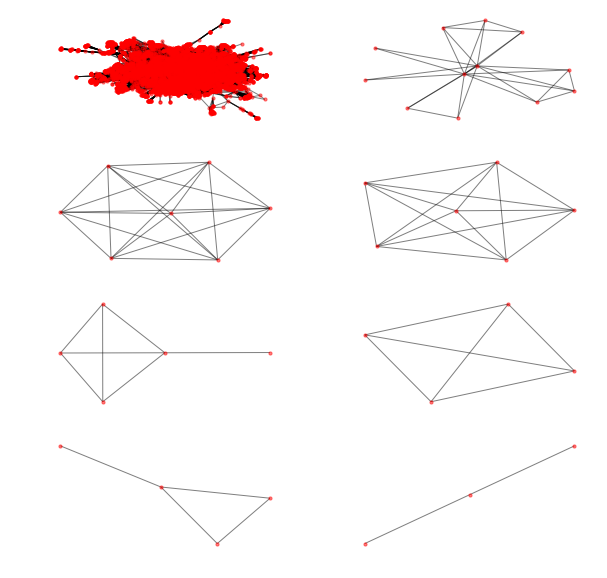

In [92]:
fig2= plt.figure(figsize=(10,10))
for i, g in enumerate(Gcc,1):
    ax = fig2.add_subplot(4,2,i)
    nx.draw(G=g, pos=nx.spring_layout(g), alpha=.5, ax=ax, node_size=10)

In [12]:
main_gcc = Gcc[0] # the largest connected component
main_gcc.name = 'GCC of infnet'
print nx.info(main_gcc)

Name: GCC of infnet
Type: Graph
Number of nodes: 7857
Number of edges: 35783
Average degree:   9.1086


In [95]:
# Diameter:
print 'Diameter of graph:', nx.diameter(main_gcc)

Diameter of graph: 10


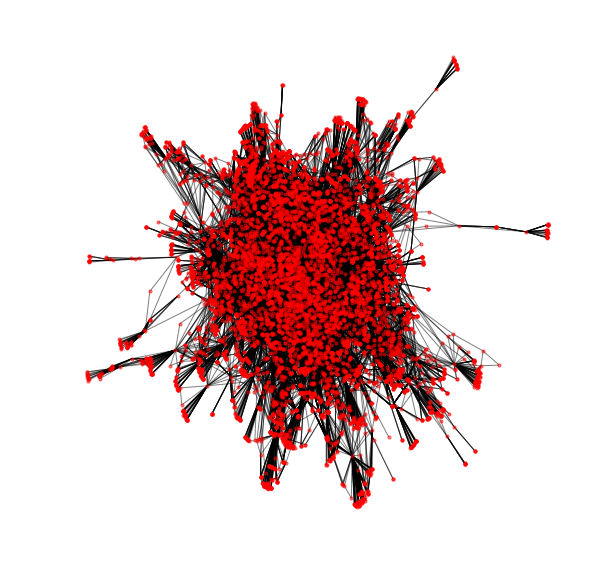

In [98]:
fig_GCC = plt.figure(figsize=(10, 10))
nx.draw(
    main_gcc,
    ax=fig_GCC.add_subplot(111),
    pos=nx.spring_layout(main_gcc),
    alpha=.5,
    node_size=10)

#### Community Detection
In this section, we use the [`community`](https://bitbucket.org/taynaud/python-louvain) package to detect communities in the largest connected component. 
We hypothesised that this will allow us to detect various institutes that have close working relationships

***Credit: https://blog.dominodatalab.com/social-network-analysis-with-networkx/***

In [13]:
import community

In [14]:
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]

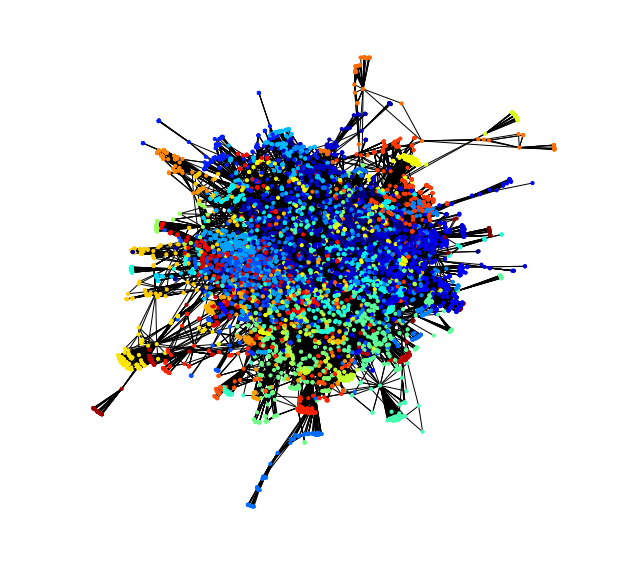

In [111]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
nx.draw_networkx(main_gcc, pos = nx.spring_layout(main_gcc), 
                 cmap = plt.get_cmap("jet"), ax=ax,
                 node_color = values, node_size = 10, with_labels = False)
plt.axis('off')
plt.show()

In [108]:
num_comm = len(set(parts.values()))
print 'Number of communities detected =', num_comm

Number of communities detected = 40


In [ ]:
pos = nx.spring_layout(main_gcc)

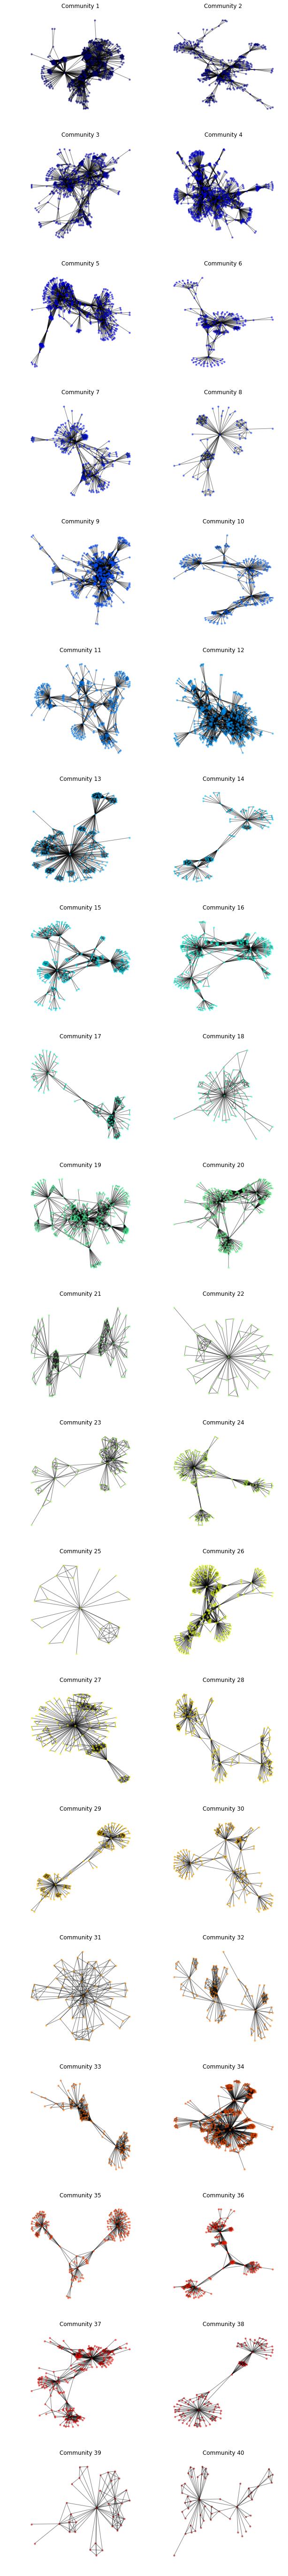

In [157]:
# Generate some values based on the communities detected:
fig = plt.figure(figsize=(10, 100))
cm = plt.get_cmap('jet')
count = 0.

for com in set(parts.values()):
    list_nodes = [nodes for nodes in parts.keys() if parts[nodes] == com]
    # Draw only the community:
    sub_graph = main_gcc.subgraph(list_nodes)
    ax = fig.add_subplot(20, 2, count + 1)
    nx.draw_networkx(
        sub_graph,
        pos=nx.spring_layout(sub_graph),
        node_size=10,
        alpha=.5,
        ax=ax,
        node_color=list(cm(count // 1 * 1.0 / num_comm)),
        with_labels=False)
    count = count + 1.
    ax.set_title('Community {}'.format(int(count)))
    ax.axis('off')

#### Finding important individuals in the GCC

In [15]:
from multiprocessing import Pool
import itertools

In [18]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [19]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [20]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [51]:
bt = between_parallel(main_gcc)

In [34]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [47]:
top = 100

max_nodes = sorted(bt.iteritems(), key=lambda v: -v[1])[:top]
bt_values = [2] * len(main_gcc.nodes())
bt_colors = [0] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = 100
    bt_colors[_nodes.index(max_key)] = 2

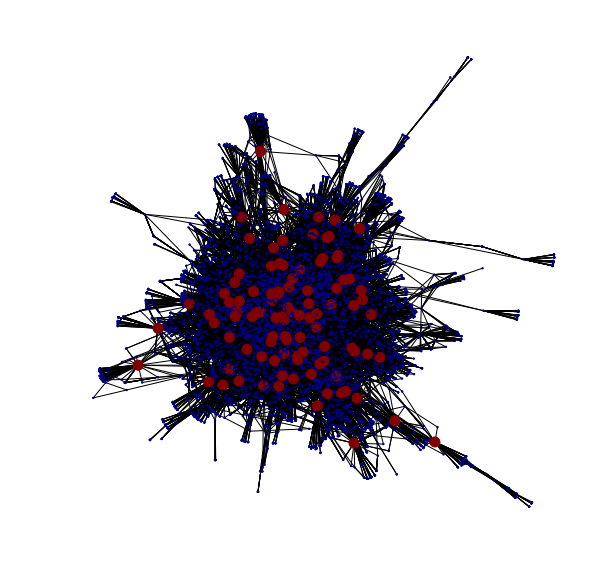

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
nx.draw_networkx(
    main_gcc,
    pos=pos,
    ax=ax,
    cmap=plt.get_cmap("jet"),
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)

Top 10 most important individuals:

In [52]:
max_nodes = sorted(bt.iteritems(), key=lambda v: -v[1])[:top]
max_nodes

[('3593b144-170a-4242-90cf-16ffbe82f45f', 0.07664970107164415),
 ('8e51eafb-dd78-468b-8970-ec2349e92305', 0.07296581850222943),
 ('0e635bd1-f0fb-4f16-a68a-d0457b80eed7', 0.06914922204142403),
 ('da3124d7-44f9-4199-82bf-9e964f422ab9', 0.06817470233413017),
 ('bfb547ed-a4df-4a6c-b1be-8ecd9b13419f', 0.05856016689484102),
 ('dfd98db5-9b1d-43d3-ad29-8a584195cdb8', 0.05209625704301999),
 ('90396347-473b-4fba-8b1d-a1d25ea18b6b', 0.048286653658093655),
 ('d953e950-362d-434f-a8bb-b1353136a030', 0.0480210839042709),
 ('2b06b072-20c7-48d5-90cd-ec9c59205b49', 0.044524701734114595),
 ('9cb66eca-0de2-438b-8896-9c5d6d748601', 0.04401815746503632)]

In [49]:
top = 10

max_nodes = sorted(bt.iteritems(), key=lambda v: -v[1])[:top]
bt_values = [2] * len(main_gcc.nodes())
bt_colors = [0] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = 100
    bt_colors[_nodes.index(max_key)] = 2

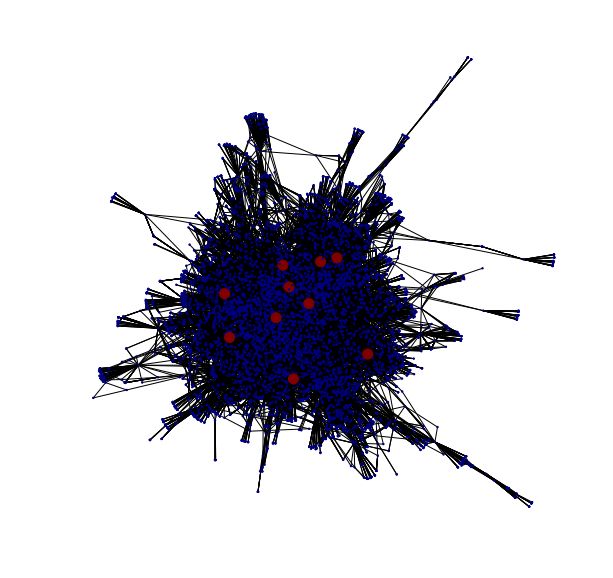

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
nx.draw_networkx(
    main_gcc,
    pos=pos,
    ax=ax,
    cmap=plt.get_cmap("jet"),
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)